In [140]:
import zipfile
import os
import shutil

shutil.rmtree('/content/data_fer', ignore_errors=True)
shutil.rmtree('/content/data_frames', ignore_errors=True)

# Extraer FER2013
dataset_zip = 'datos.tfg.zip'
extract_dataset_to = '/content/data_fer'
os.makedirs(extract_dataset_to, exist_ok=True)

with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_dataset_to)

print(" Dataset FER extraído en:", extract_dataset_to)

# Extraer Frames2
frames_zip = 'Frames2.zip'
extract_frames_to = '/content/data_frames'
os.makedirs(extract_frames_to, exist_ok=True)

with zipfile.ZipFile(frames_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_frames_to)

print(" Frames extraídos en:", extract_frames_to)


 Dataset FER extraído en: /content/data_fer
 Frames extraídos en: /content/data_frames


In [141]:
import os

#Ruta base del FER ya extraído
fer_base = '/content/data_fer'

emociones_en_es = {
    'angry': 'Enfadado',
    'fear': 'Miedo',
    'happy': 'Feliz',
    'sad': 'Triste',
    'surprise': 'Sorpresa',
    'neutral': 'Neutral'
}

#Recorrer carpetas 'train' y 'test'
for subset in ['train', 'test']:
    subset_path = os.path.join(fer_base, subset)
    for folder_name in os.listdir(subset_path):
        folder_path = os.path.join(subset_path, folder_name)
        if os.path.isdir(folder_path) and folder_name in emociones_en_es:
            nuevo_nombre = emociones_en_es[folder_name]
            nueva_ruta = os.path.join(subset_path, nuevo_nombre)
            os.rename(folder_path, nueva_ruta)
            print(f" {subset}/{folder_name} → {nuevo_nombre}")



 train/angry → Enfadado
 train/fear → Miedo
 train/happy → Feliz
 train/neutral → Neutral
 train/sad → Triste
 train/surprise → Sorpresa
 test/angry → Enfadado
 test/fear → Miedo
 test/happy → Feliz
 test/neutral → Neutral
 test/sad → Triste
 test/surprise → Sorpresa


In [142]:
import os
import shutil
import random


fer_dir = '/content/data_fer'
frames_dir = '/content/data_frames/Frames2'
output_dir = '/content/dataset_final'

emociones = ['Enfadado', 'Miedo', 'Feliz', 'Triste', 'Sorpresa', 'Neutral']

for subset in ['train', 'test']:
    for emocion in emociones:
        path = os.path.join(output_dir, subset, emocion)
        os.makedirs(path, exist_ok=True)

#Copiar imágenes del FER (ya están divididas en train/test)
for subset in ['train', 'test']:
    for emocion in emociones:
        origen = os.path.join(fer_dir, subset, emocion)
        destino = os.path.join(output_dir, subset, emocion)
        if os.path.exists(origen):
            for i, file in enumerate(os.listdir(origen)):
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    nuevo_nombre = f"fer_{i:05d}.png"
                    shutil.copy(os.path.join(origen, file), os.path.join(destino, nuevo_nombre))

print(" Imágenes FER copiadas y renombradas.")

#Copiar imágenes del vídeo (frames) y dividir en train/test 80/20
for emocion in emociones:
    origen = os.path.join(frames_dir, emocion)
    if os.path.exists(origen):
        archivos = [f for f in os.listdir(origen) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        random.shuffle(archivos)
        corte = int(len(archivos) * 0.8)
        train_files = archivos[:corte]
        test_files = archivos[corte:]

        for i, f in enumerate(train_files):
            dst = os.path.join(output_dir, 'train', emocion, f"video_{i:05d}.png")
            shutil.copy(os.path.join(origen, f), dst)

        for i, f in enumerate(test_files):
            dst = os.path.join(output_dir, 'test', emocion, f"video_{i:05d}.png")
            shutil.copy(os.path.join(origen, f), dst)

print(" Imágenes del vídeo copiadas, divididas y renombradas.")
print(" Dataset final preparado en:", output_dir)




 Imágenes FER copiadas y renombradas.
 Imágenes del vídeo copiadas, divididas y renombradas.
 Dataset final preparado en: /content/dataset_final


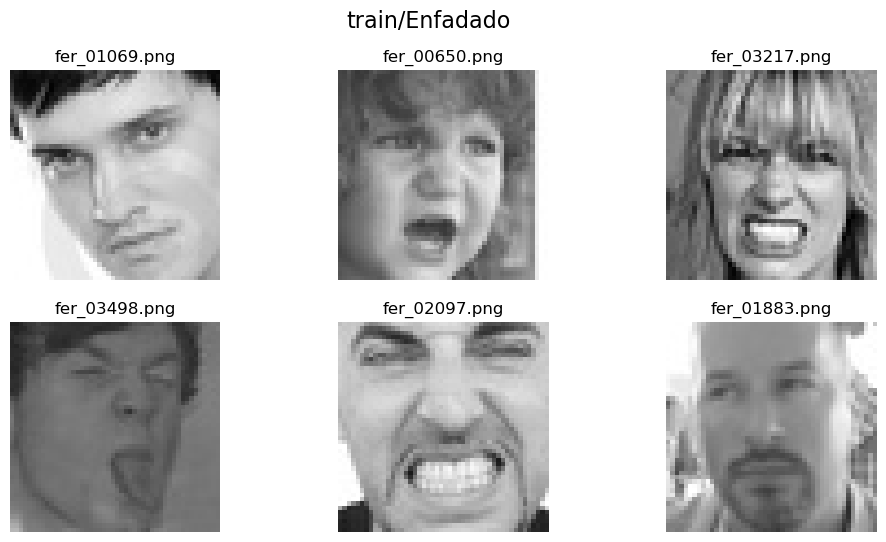

In [144]:
import matplotlib.pyplot as plt
import cv2
import random

#Imagenes aleatorias de la clase que queramos
clase = 'Enfadado'
subset = 'train'
ruta = f'/content/dataset_final/{subset}/{clase}'
archivos = os.listdir(ruta)
muestras = random.sample(archivos, 6)

plt.figure(figsize=(12, 6))
for i, nombre in enumerate(muestras):
    img = cv2.imread(os.path.join(ruta, nombre))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(nombre)
    plt.axis('off')
plt.suptitle(f'{subset}/{clase}', fontsize=16)
plt.show()



In [146]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# NUEVAS rutas
train_dir = '/content/dataset_final/train'
test_dir = '/content/dataset_final/test'



train_val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.1,
    brightness_range=(0.6, 1.3), 
    horizontal_flip=True,
    fill_mode='nearest'
)


train_generator = train_val_datagen.flow_from_directory(
    train_dir,
    target_size=(96, 96),  
    batch_size=64,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training'
)

val_generator = train_val_datagen.flow_from_directory(
    train_dir,
    target_size=(96, 96), 
    batch_size=64,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation'
)

# Dataset de test final (no augmentation, solo reescalado)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(96, 96), 
    batch_size=64,
    class_mode='categorical',
    color_mode='grayscale'
)

# Confirmación
print(" Imágenes de entrenamiento:", train_generator.samples)
print(" Imágenes de validación:", val_generator.samples)
print(" Imágenes de test:", test_generator.samples)


Found 25447 images belonging to 6 classes.
Found 6359 images belonging to 6 classes.
Found 7952 images belonging to 6 classes.
 Imágenes de entrenamiento: 25447
 Imágenes de validación: 6359
 Imágenes de test: 7952


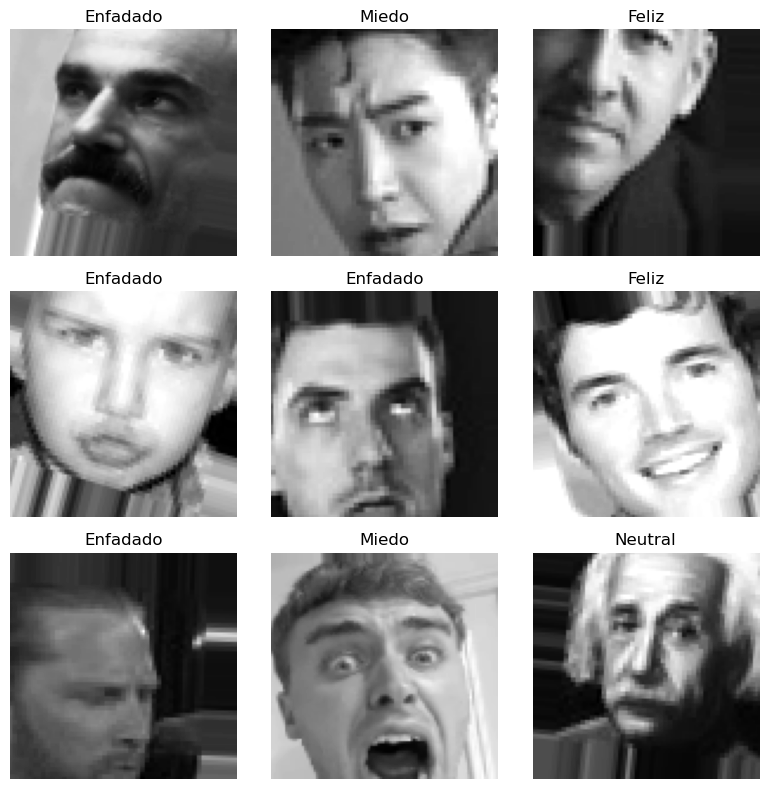

In [148]:
import matplotlib.pyplot as plt
import numpy as np

images, labels = next(train_generator)


class_names = list(train_generator.class_indices.keys())

#las primeras 9 imágenes
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
axes = axes.flatten()

for img, label, ax in zip(images[:9], labels[:9], axes):
    clase_idx = np.argmax(label)
    clase_nombre = class_names[clase_idx]

    img = img.squeeze()

    ax.imshow(img, cmap='gray') 
    ax.set_title(clase_nombre)
    ax.axis('off')

plt.tight_layout()
plt.show()

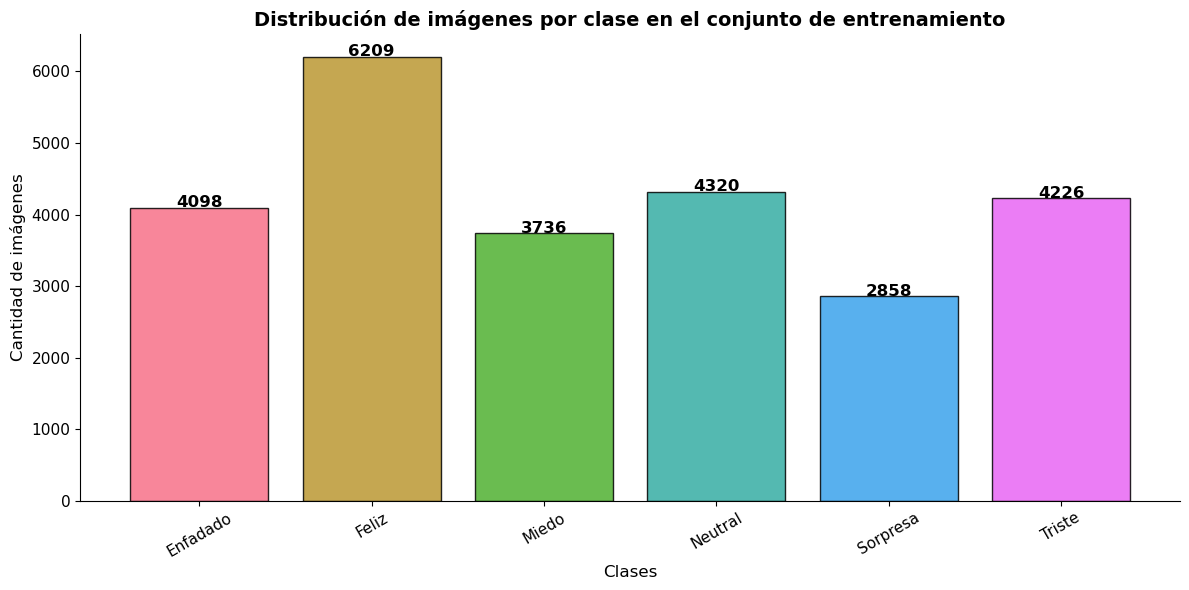

In [150]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Contar imágenes por clase
class_counts = {class_name: np.sum(train_generator.classes == class_idx) 
                for class_name, class_idx in train_generator.class_indices.items()}

#figura
plt.figure(figsize=(12, 6))
colors = sns.color_palette("husl", len(class_counts))

#Graficar la distribución con barras mejoradas
bars = plt.bar(class_counts.keys(), class_counts.values(), color=colors, edgecolor="black", alpha=0.85)

#Añadir etiquetas con los valores en cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', fontsize=12, fontweight='bold', color='black')

plt.title("Distribución de imágenes por clase en el conjunto de entrenamiento", fontsize=14, fontweight='bold')
plt.xlabel("Clases", fontsize=12)
plt.ylabel("Cantidad de imágenes", fontsize=12)
plt.xticks(rotation=30, fontsize=11)
plt.yticks(fontsize=11)
sns.despine()

plt.tight_layout()
plt.show()



In [151]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, Concatenate
import tensorflow as tf

#Entrenamiento final limpio (dataset con rostros recortados y sin ruido)

input_shape = (96, 96, 1)
input_tensor = Input(shape=input_shape)

# Convertir a 3 canales para MobileNetV2
x = Concatenate()([input_tensor, input_tensor, input_tensor])  # (96, 96, 3)

# Modelo base
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=x)

# Capas superiores
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)  # Dropout aumentado
output = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)




In [152]:
from sklearn.utils import class_weight
import numpy as np

labels = train_generator.classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}
print("Pesos por clase:", class_weight_dict)



Pesos por clase: {0: 1.0349357410118758, 1: 0.6830675900574434, 2: 1.1352159172019987, 3: 0.9817515432098766, 4: 1.4839631443900163, 5: 1.0035888941473419}


In [153]:
from tensorflow.keras.optimizers import Adam

# Descongelar últimas 100 capas
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print(f"Capas descongeladas desde la {fine_tune_at} de {len(base_model.layers)} capas.")

# Compilación
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



Capas descongeladas desde la 55 de 155 capas.


In [160]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6)
checkpoint = ModelCheckpoint('mejor_modelo_limpio.keras', monitor='val_loss', save_best_only=True)

# Entrenamiento desde 0
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)




Epoch 1/100
398/398 [==============================] - 269s 670ms/step - loss: 1.2109 - accuracy: 0.5313 - val_loss: 1.3542 - val_accuracy: 0.4732 - lr: 1.0000e-05
Epoch 2/100
398/398 [==============================] - 232s 582ms/step - loss: 1.1903 - accuracy: 0.5416 - val_loss: 1.3417 - val_accuracy: 0.4721 - lr: 1.0000e-05
Epoch 3/100
398/398 [==============================] - 228s 573ms/step - loss: 1.1826 - accuracy: 0.5459 - val_loss: 1.3308 - val_accuracy: 0.4861 - lr: 1.0000e-05
Epoch 4/100
398/398 [==============================] - 238s 599ms/step - loss: 1.1603 - accuracy: 0.5515 - val_loss: 1.3185 - val_accuracy: 0.4883 - lr: 1.0000e-05
Epoch 5/100
398/398 [==============================] - 242s 609ms/step - loss: 1.1472 - accuracy: 0.5565 - val_loss: 1.2948 - val_accuracy: 0.4932 - lr: 1.0000e-05
Epoch 6/100
398/398 [==============================] - 240s 604ms/step - loss: 1.1394 - accuracy: 0.5602 - val_loss: 1.2863 - val_accuracy: 0.5001 - lr: 1.0000e-05
Epoch 7/100
398/

In [161]:
model.save('modelo.pelicula2.keras')
print(" Modelo final guardado como 'modelo_pelicula.keras'")


 Modelo final guardado como 'modelo_pelicula.keras'


In [162]:
from tensorflow.keras.models import load_model

# Cargar el nuevo modelo definitivo
modelo_definitivo = load_model('modelo.pelicula2.keras')

# Evaluar en el conjunto de test
loss, accuracy = modelo_definitivo.evaluate(test_generator, verbose=1)
print(f" Precisión en test: {accuracy:.4f} — Pérdida: {loss:.4f}")


125/125 [==============================] - 42s 295ms/step - loss: 0.9759 - accuracy: 0.6366
 Precisión en test: 0.6366 — Pérdida: 0.9759


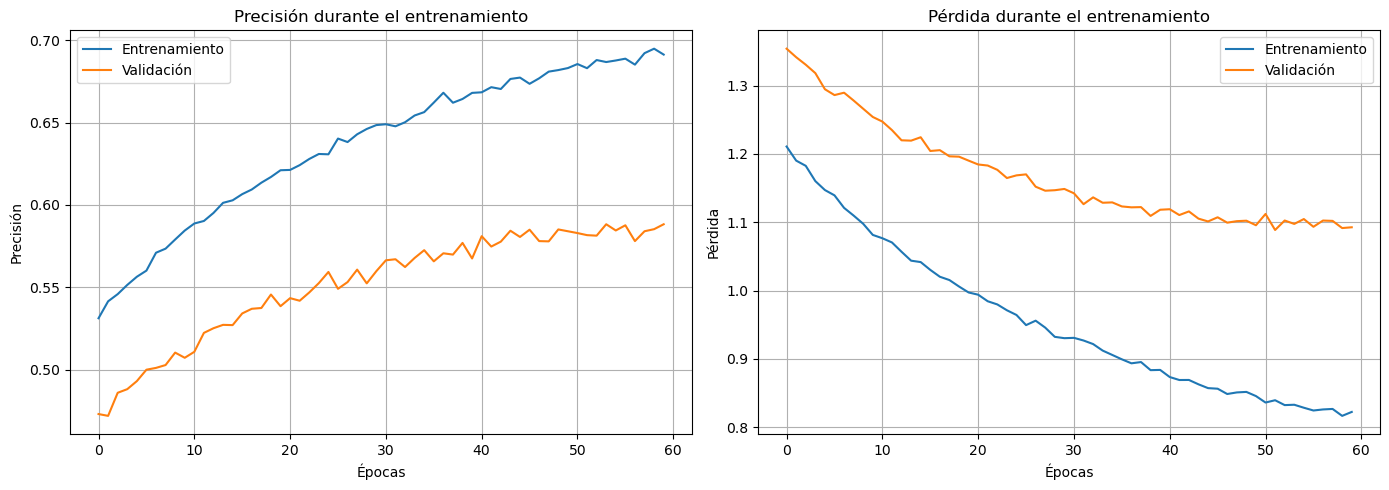

In [163]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


125/125 [==============================] - 37s 271ms/step
 Clasificación detallada:

              precision    recall  f1-score   support

    Enfadado       0.15      0.13      0.14      1240
       Feliz       0.25      0.29      0.27      1911
       Miedo       0.14      0.09      0.11      1167
     Neutral       0.16      0.26      0.20      1342
    Sorpresa       0.12      0.11      0.12       932
      Triste       0.16      0.11      0.13      1360

    accuracy                           0.18      7952
   macro avg       0.16      0.16      0.16      7952
weighted avg       0.17      0.18      0.17      7952



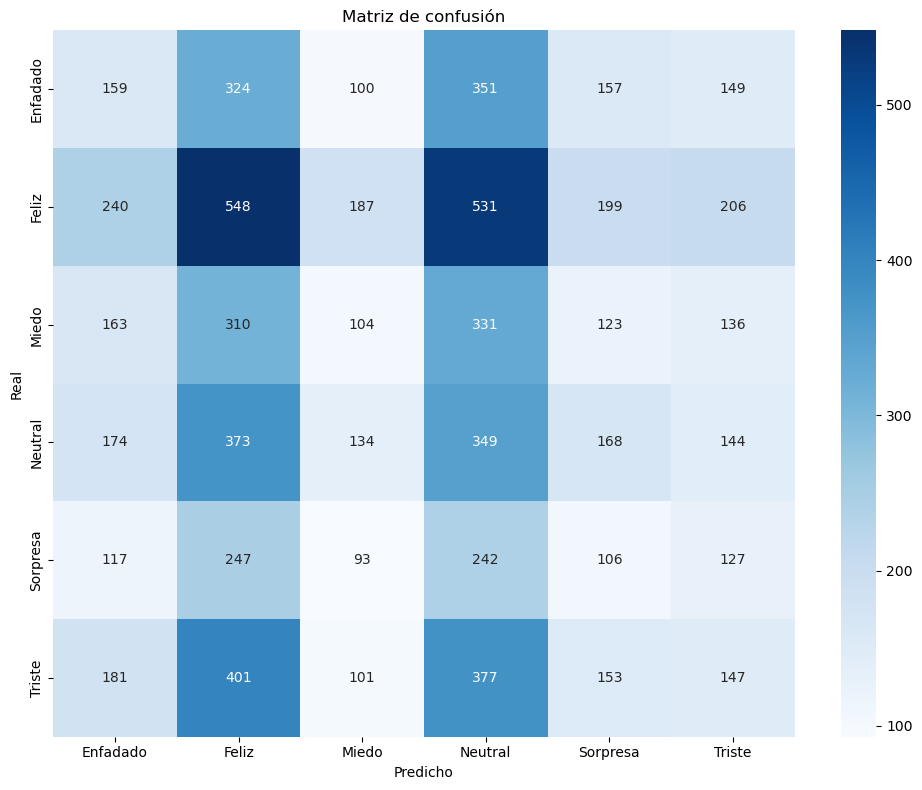

In [164]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Obtener etiquetas verdaderas
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Obtener predicciones del modelo cargado
y_pred_prob = modelo_definitivo.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

# Clasificación por clase
print(" Clasificación detallada:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de confusión')
plt.tight_layout()
plt.show()



In [165]:
from tensorflow.keras.models import load_model
import shutil

#  Cargar el modelo .keras
modelo = load_model("modelo.pelicula2.keras")

# Guardar en formato SavedModel (carpeta)
modelo.save("modelo_pelicula3")
print(" SavedModel exportado en carpeta 'modelo_exportado_definitivo/'")

#  Comprimir la carpeta como ZIP
shutil.make_archive("modelo_pelicula3", "zip", "modelo_pelicula3")
print(" Archivo ZIP creado: modelo_pelicula2.zip")


INFO:tensorflow:Assets written to: modelo_pelicula3\assets


INFO:tensorflow:Assets written to: modelo_pelicula3\assets


 SavedModel exportado en carpeta 'modelo_exportado_definitivo/'
 Archivo ZIP creado: modelo_pelicula2.zip


In [71]:
import cv2
import os

video_path = 'video_casero3.mp4'
output_folder = 'frames_casero3'
os.makedirs(output_folder, exist_ok=True)

cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print(" No se pudo abrir el vídeo. Revisa la ruta o el formato.")
else:
    print(" Vídeo cargado correctamente.")
    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        filename = os.path.join(output_folder, f"frame_{frame_count:05d}.jpg")
        cv2.imwrite(filename, frame)
        frame_count += 1

    cap.release()
    print(f" {frame_count} imágenes extraídas en: {output_folder}")


 Vídeo cargado correctamente.
 7570 imágenes extraídas en: frames_PELICULA


In [139]:
import os

carpeta_origen = 'frames_casero3'  

imagenes = sorted([f for f in os.listdir(carpeta_origen) if f.endswith('.jpg') or f.endswith('.png')])

for i, nombre in enumerate(imagenes):
    nuevo_nombre = f"LIMPIOss_{i:05d}_{nombre}"  # mantiene orden y evita conflicto
    ruta_original = os.path.join(carpeta_origen, nombre)
    ruta_nueva = os.path.join(carpeta_origen, nuevo_nombre)
    os.rename(ruta_original, ruta_nueva)

print(" Imágenes renombradas sin desorden")



 Imágenes renombradas sin desorden


In [72]:
import cv2
import os

carpeta_entrada = 'frames_casero3'

carpeta_salida = 'limpios_casero3'
os.makedirs(carpeta_salida, exist_ok=True)

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

for nombre_archivo in sorted(os.listdir(carpeta_entrada)):
    ruta_imagen = os.path.join(carpeta_entrada, nombre_archivo)
    imagen = cv2.imread(ruta_imagen)

    if imagen is None:
        continue

    gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    rostros = face_cascade.detectMultiScale(gris, scaleFactor=1.1, minNeighbors=5)

    if len(rostros) == 0:
        continue  

    x, y, w, h = rostros[0]
    margen = 20
    x = max(x - margen, 0)
    y = max(y - margen, 0)
    w = min(w + 2 * margen, imagen.shape[1] - x)
    h = min(h + 2 * margen, imagen.shape[0] - y)
    rostro_recortado = imagen[y:y+h, x:x+w]

    cv2.imwrite(os.path.join(carpeta_salida, nombre_archivo), rostro_recortado)

print(" Rostros recortados y guardados en:", carpeta_salida)


 Rostros recortados y guardados en: LIMPIOS_PELICULA
